In [3]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split



def load_and_preprocess_data(image_folder, label_folder):
    images = []
    labels = []

    for image_file in os.listdir(image_folder):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(image_folder, image_file)
            label_file = os.path.join(label_folder, image_file.replace(".jpg", ".json"))

            if os.path.exists(label_file):
                with open(label_file, 'r') as f:
                    label_data = json.load(f)

                
                image = load_img(image_path, target_size=(PNET_IMAGE_SIZE, PNET_IMAGE_SIZE))
                image = img_to_array(image) / 255.0

                images.append(image)
                labels.append(label_data)

    return images, labels


train_image_folder = '/kaggle/input/images-with-labels/aug_data/train/images'
train_label_folder = '/kaggle/input/images-with-labels/aug_data/train/labels'

val_image_folder = '/kaggle/input/images-with-labels/aug_data/val/images'
val_label_folder = '/kaggle/input/images-with-labels/aug_data/val/labels'

test_image_folder = '/kaggle/input/images-with-labels/aug_data/test/images'
test_label_folder = '/kaggle/input/images-with-labels/aug_data/test/labels'


PNET_IMAGE_SIZE = 160


train_images, train_labels = load_and_preprocess_data(train_image_folder, train_label_folder)
val_images, val_labels = load_and_preprocess_data(val_image_folder, val_label_folder)
test_images, test_labels = load_and_preprocess_data(test_image_folder, test_label_folder)


train_labels = {
    'bbox_output': tf.constant([label['bbox'] for label in train_labels]),
    'class_output': tf.constant([label['class'] for label in train_labels])
}

val_labels = {
    'bbox_output': tf.constant([label['bbox'] for label in val_labels]),
    'class_output': tf.constant([label['class'] for label in val_labels])
}

test_labels = {
    'bbox_output': tf.constant([label['bbox'] for label in test_labels]),
    'class_output': tf.constant([label['class'] for label in test_labels])
}


train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
val_images = tf.convert_to_tensor(val_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)


train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))


BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
# import numpy
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# # Get the size of the image
# image_size = train_images.size

# # Print the image size
# print("Image size:", image_size)

Model: "p_net_model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         multiple                  897       
                                                                 
 conv2d_137 (Conv2D)         multiple                  9249      
                                                                 
 max_pooling2d_69 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 dropout_92 (Dropout)        multiple                  0         
                                                                 
 conv2d_138 (Conv2D)         multiple                  18497     
                                                                 
 conv2d_139 (Conv2D)         multiple                  36929     
                                                    

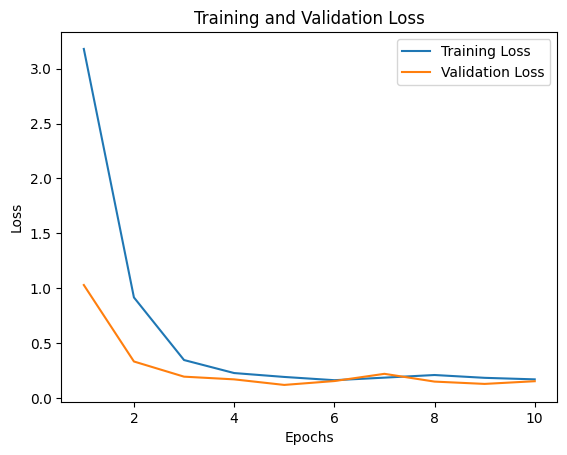

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np
import os


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)


class PReLU(layers.Layer):
    def __init__(self, **kwargs):
        super(PReLU, self).__init__(**kwargs)

    def build(self, input_shape):
        self.alpha = self.add_weight(
            shape=(1,),
            initializer=tf.initializers.Constant(0.25), 
            trainable=True,
            name='alpha'
        )
        super(PReLU, self).build(input_shape)

    def call(self, inputs):
        return tf.nn.relu(inputs) - self.alpha * tf.nn.relu(-inputs)


class PNetModel(tf.keras.Model):
    def __init__(self):
        super(PNetModel, self).__init__()

        self.conv1 = layers.Conv2D(32, (3, 3), activation=PReLU(), kernel_regularizer=regularizers.l2(0.01))
        self.conv2 = layers.Conv2D(32, (3, 3), activation=PReLU(), kernel_regularizer=regularizers.l2(0.01))
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.5)

        self.conv3 = layers.Conv2D(64, (3, 3), activation=PReLU(), kernel_regularizer=regularizers.l2(0.01))
        self.conv4 = layers.Conv2D(64, (3, 3), activation=PReLU(), kernel_regularizer=regularizers.l2(0.01))
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.5)

        self.conv5 = layers.Conv2D(128, (3, 3), activation=PReLU(), kernel_regularizer=regularizers.l2(0.01))
        self.conv6 = layers.Conv2D(128, (3, 3), activation=PReLU(), kernel_regularizer=regularizers.l2(0.01))
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.5)

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(256, activation=PReLU())
        self.dropout4 = layers.Dropout(0.5)

        # Output layers for bounding box regression and class prediction
        self.bbox_output = layers.Dense(4, name='bbox_output')  # 4 for bounding box coordinates
        self.class_output = layers.Dense(1, activation='sigmoid', name='class_output')  # 1 for binary classification

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout4(x)

        bbox_output = self.bbox_output(x)
        class_output = self.class_output(x)

        return {'bbox_output': bbox_output, 'class_output': class_output}


pnet_model = PNetModel()


pnet_model.build((None, PNET_IMAGE_SIZE, PNET_IMAGE_SIZE, 3))
pnet_model.summary()

pnet_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss={'bbox_output': 'mse', 'class_output': 'binary_crossentropy'},
    metrics={'bbox_output': 'mae', 'class_output': 'accuracy'}
)


train_losses = []
val_losses = []

EPOCHS = 10

for epoch in range(EPOCHS):
    epoch_train_loss = []
    for images, labels in train_dataset:
        bbox_labels = labels['bbox_output']
        class_labels = labels['class_output']

        y_true = {'bbox_output': bbox_labels, 'class_output': class_labels}

        train_loss = pnet_model.train_step([images, y_true])
        epoch_train_loss.append(train_loss)

  
    train_losses.append(tf.reduce_mean([train_loss['loss'] for train_loss in epoch_train_loss]))
   
    val_loss = pnet_model.evaluate(val_dataset)
    val_losses.append(val_loss[0])  
    print(f'Epoch {epoch+1}/{EPOCHS}, Validation Loss: {val_loss}')

# Plotting the training and validation loss
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


64/64 [==============================] - 1s 19ms/step


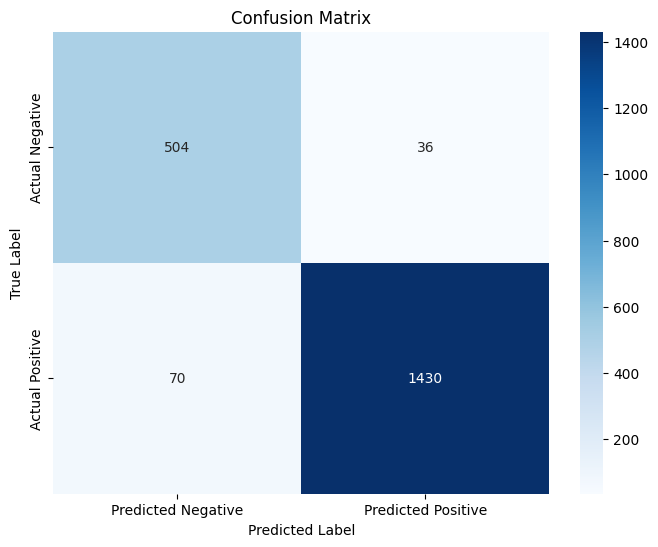

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


val_predictions = pnet_model.predict(val_dataset)

val_class_predictions = np.where(val_predictions['class_output'] > 0.5, 1, 0)  # Assuming threshold of 0.5


true_labels = np.concatenate([labels['class_output'] for _, labels in val_dataset], axis=0)


conf_matrix = confusion_matrix(true_labels, val_class_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 158ms/step


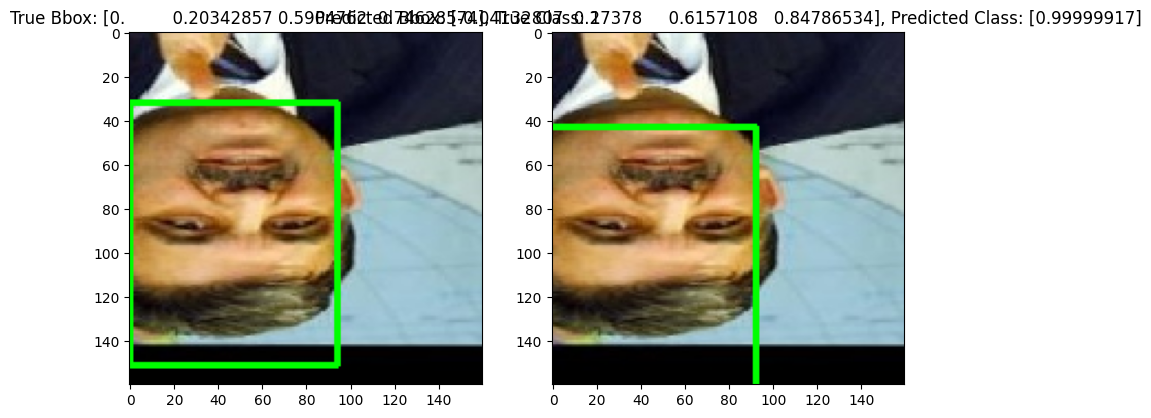

1/1 [==============================] - 0s 27ms/step


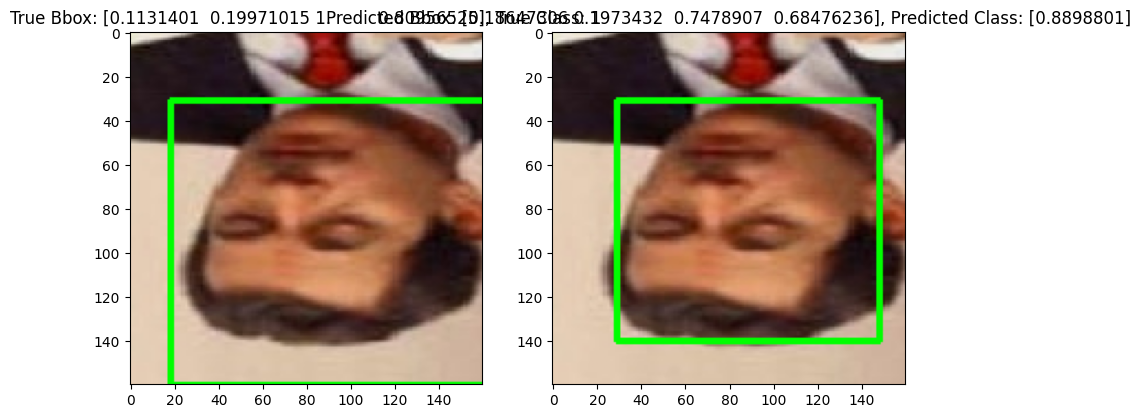

1/1 [==============================] - 0s 34ms/step


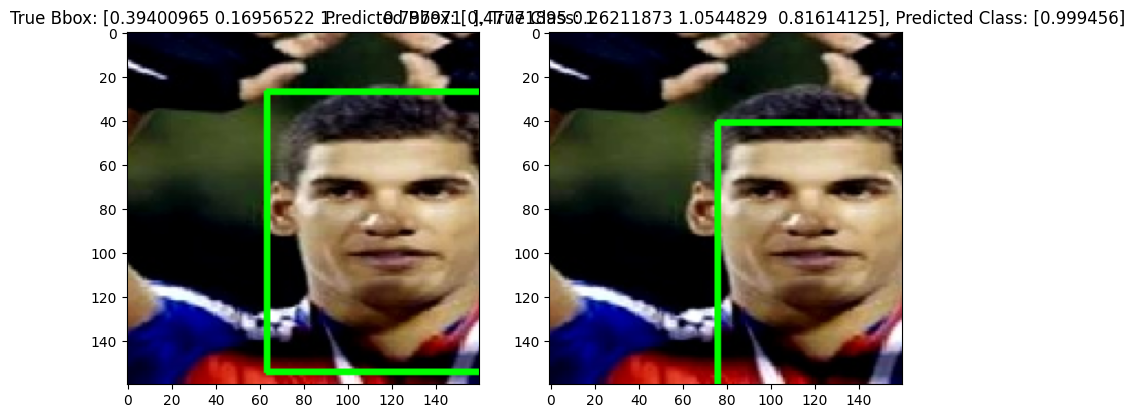

1/1 [==============================] - 0s 30ms/step


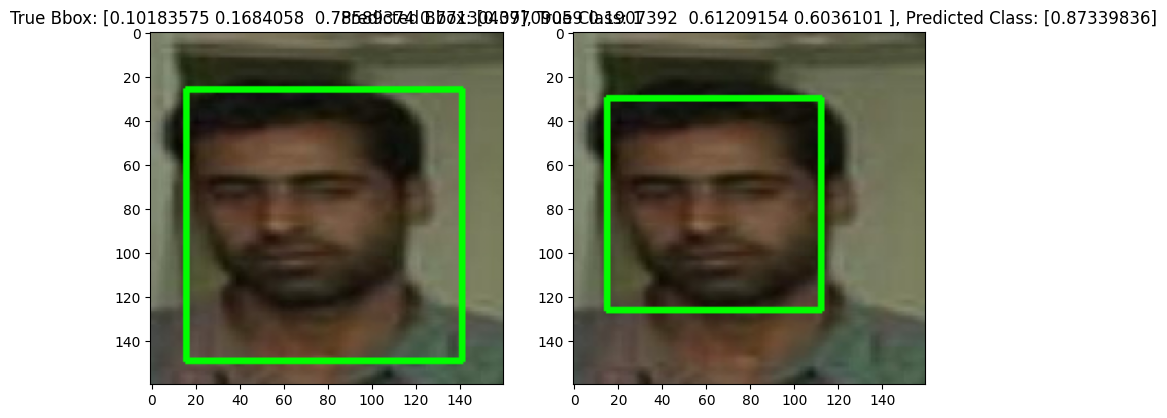

1/1 [==============================] - 0s 29ms/step


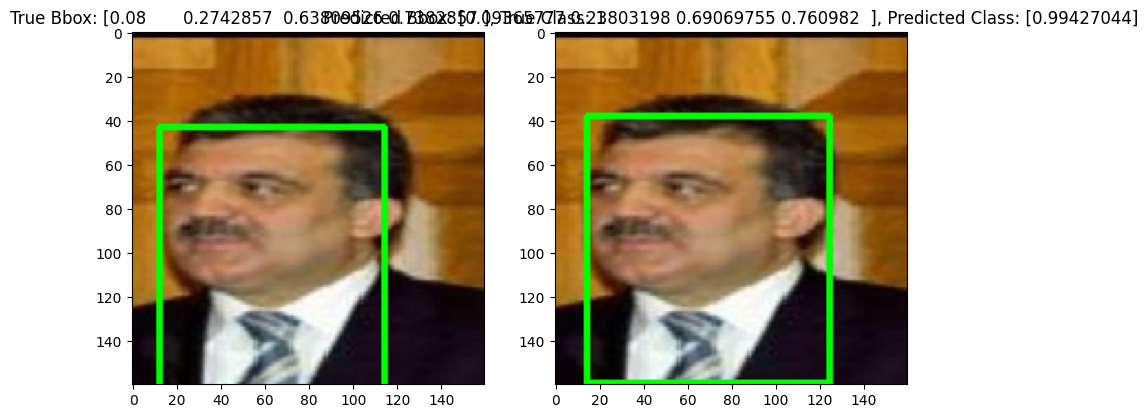

1/1 [==============================] - 0s 27ms/step


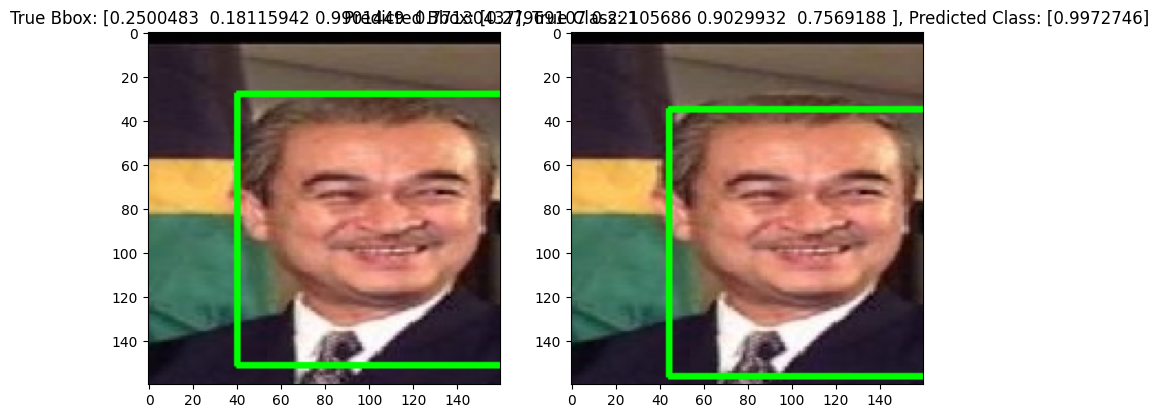

1/1 [==============================] - 0s 27ms/step


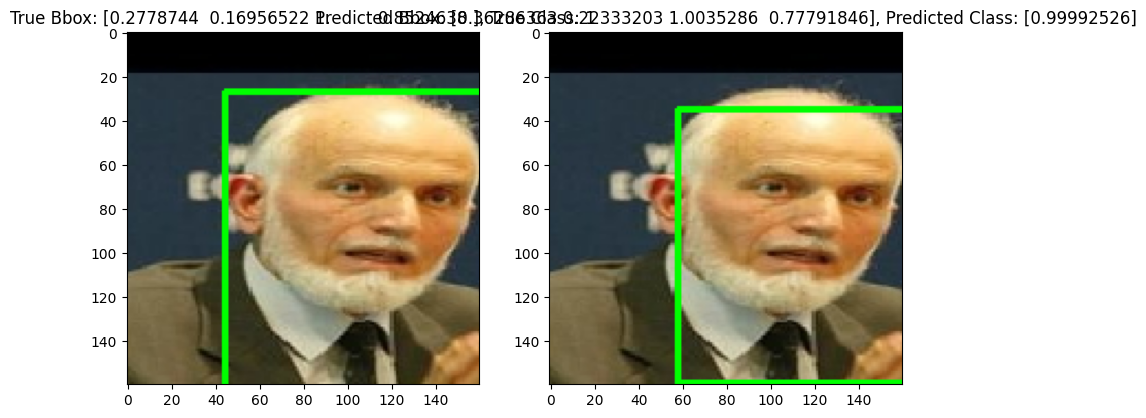

1/1 [==============================] - 0s 29ms/step


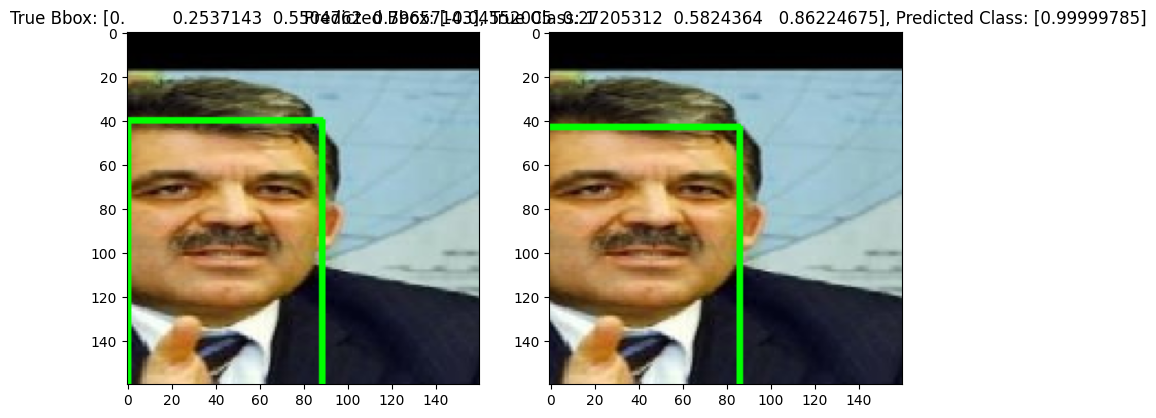

1/1 [==============================] - 0s 40ms/step


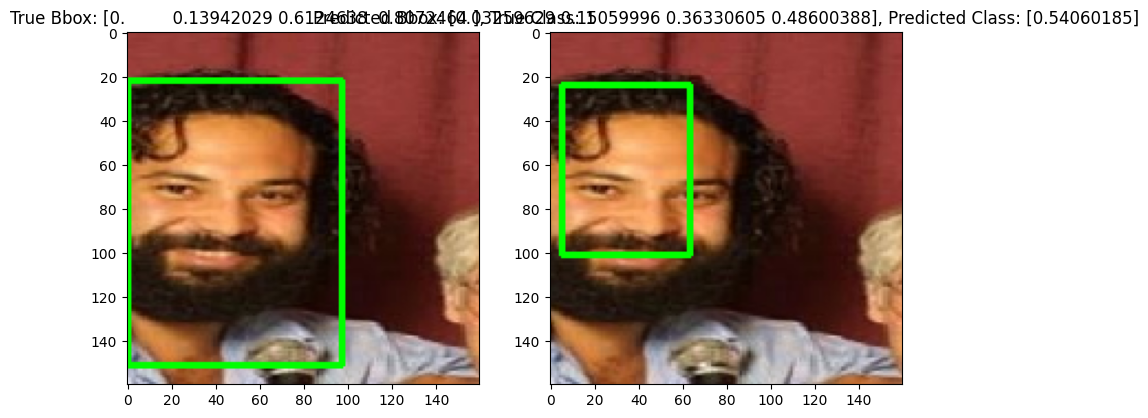

1/1 [==============================] - 0s 34ms/step


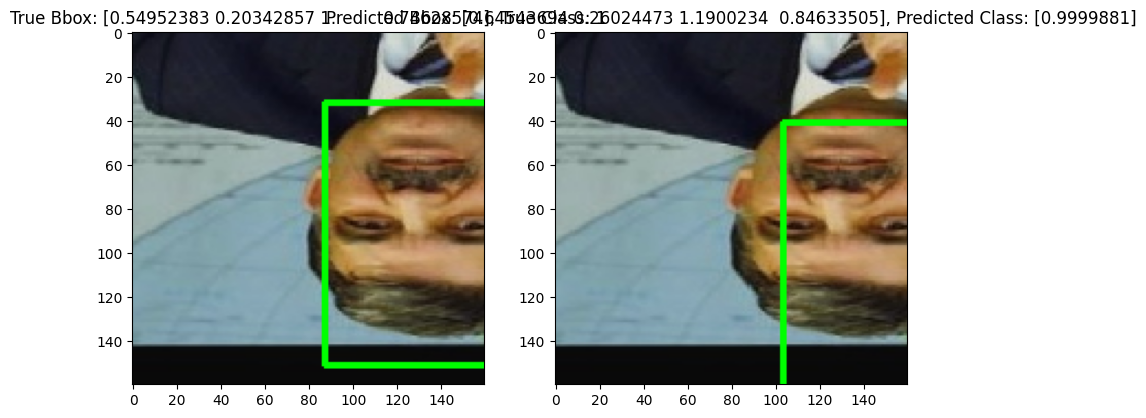

1/1 [==============================] - 0s 30ms/step


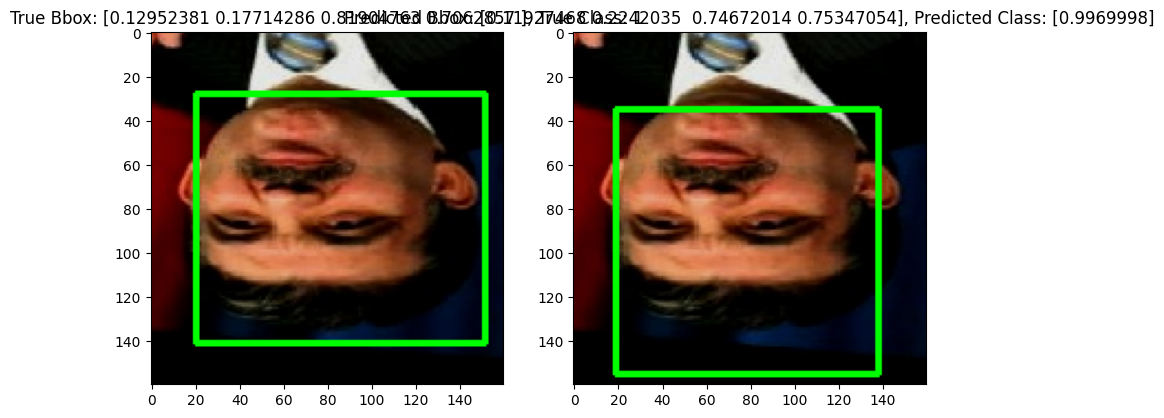

1/1 [==============================] - 0s 28ms/step


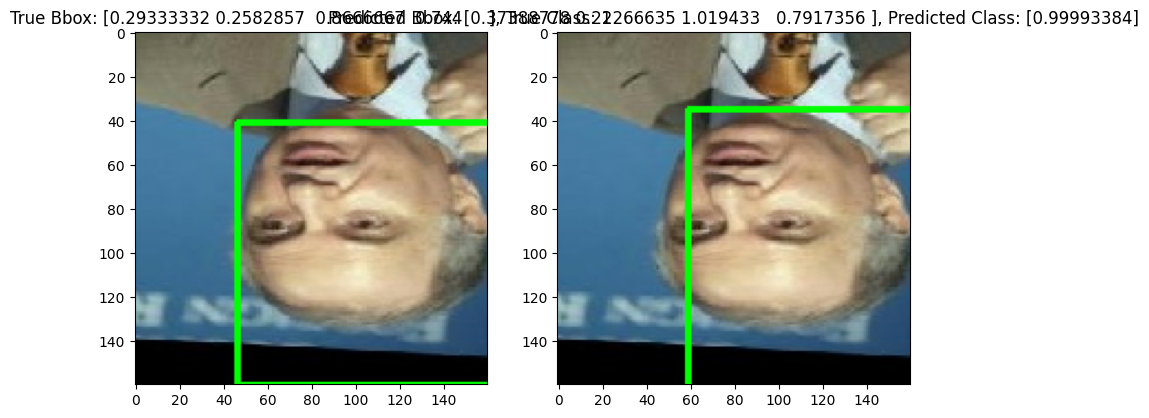

1/1 [==============================] - 0s 28ms/step


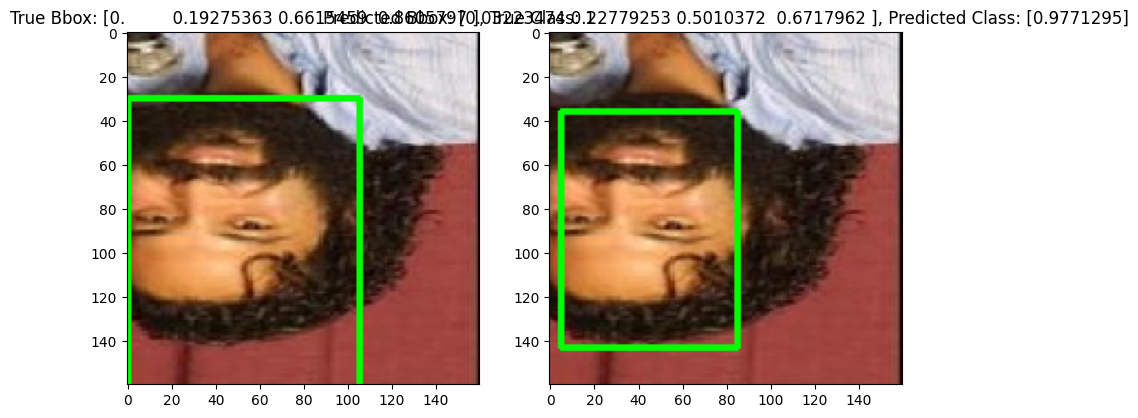

1/1 [==============================] - 0s 28ms/step


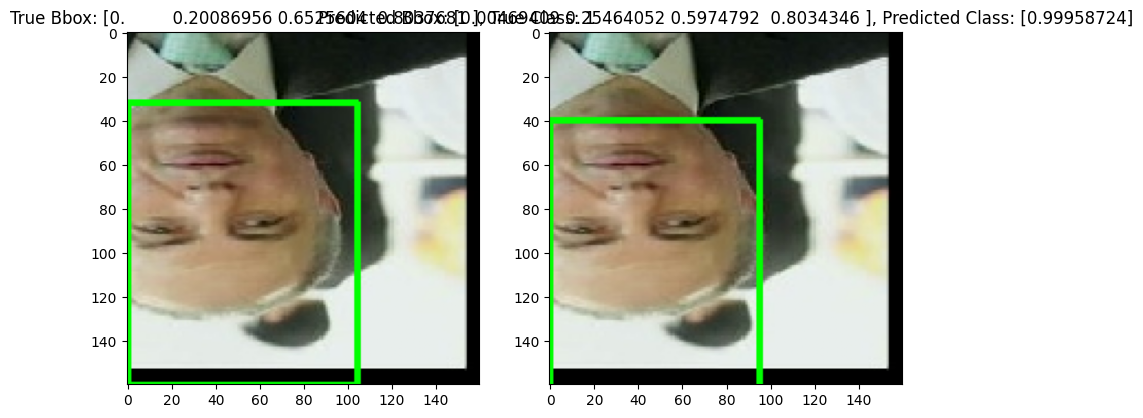

1/1 [==============================] - 0s 29ms/step


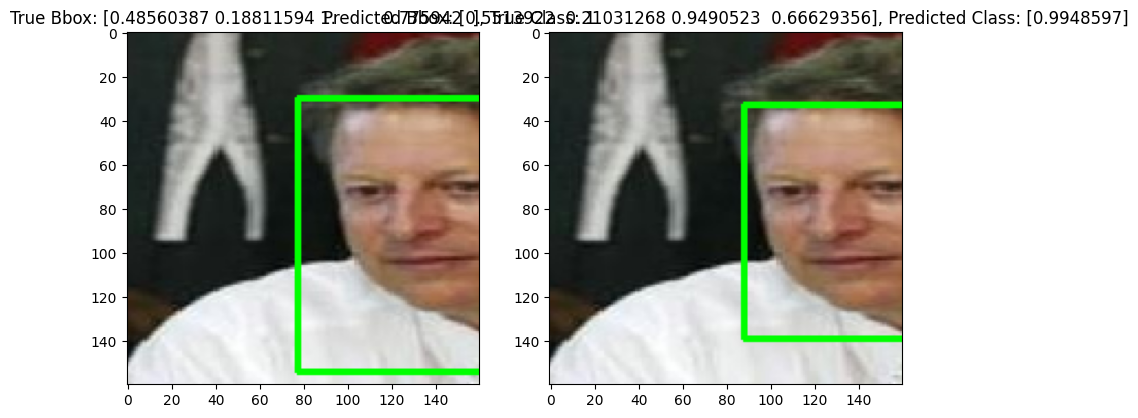

1/1 [==============================] - 0s 29ms/step


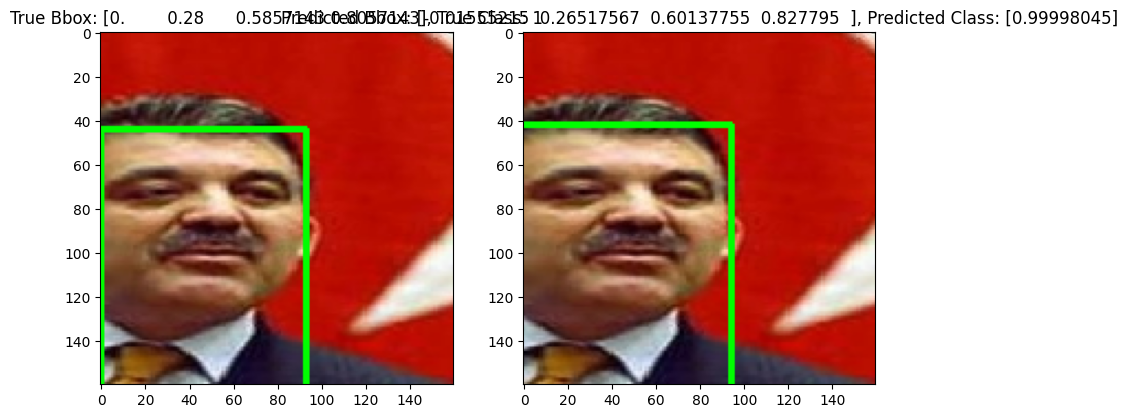

1/1 [==============================] - 0s 27ms/step


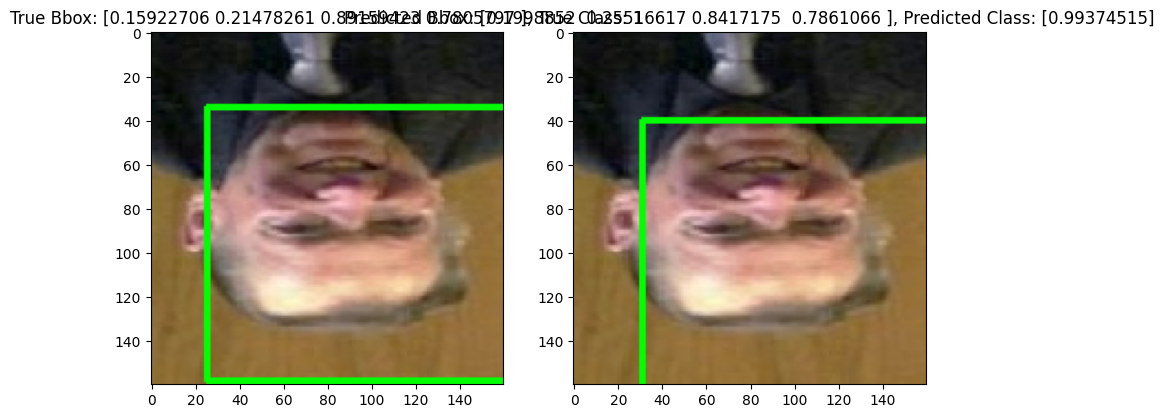

1/1 [==============================] - 0s 27ms/step


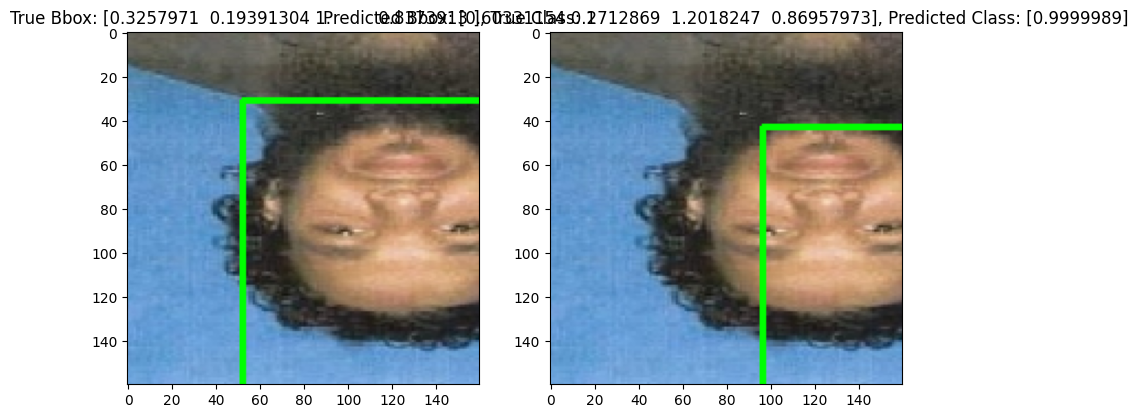

1/1 [==============================] - 0s 27ms/step


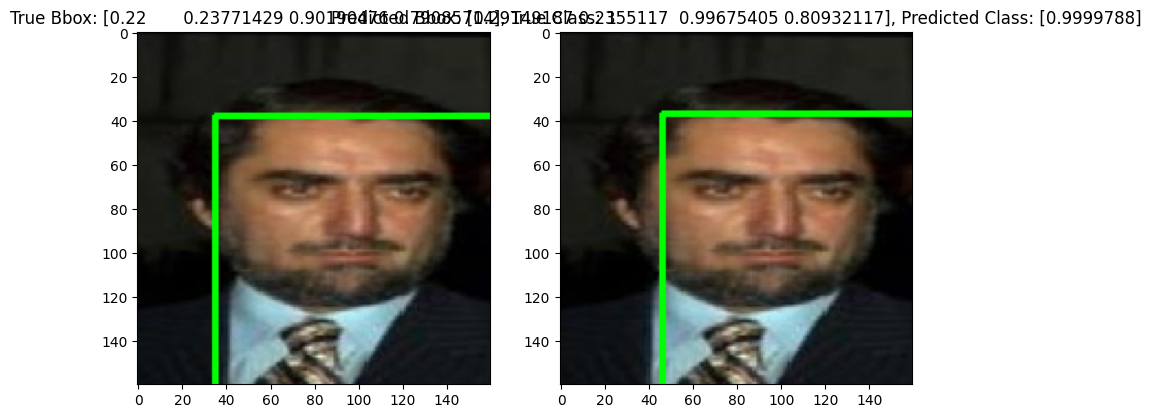

1/1 [==============================] - 0s 27ms/step


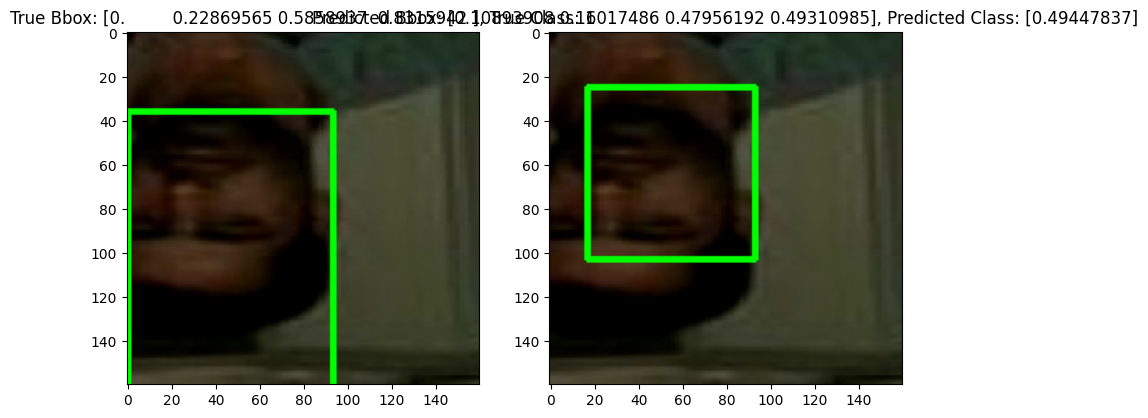

1/1 [==============================] - 0s 201ms/step


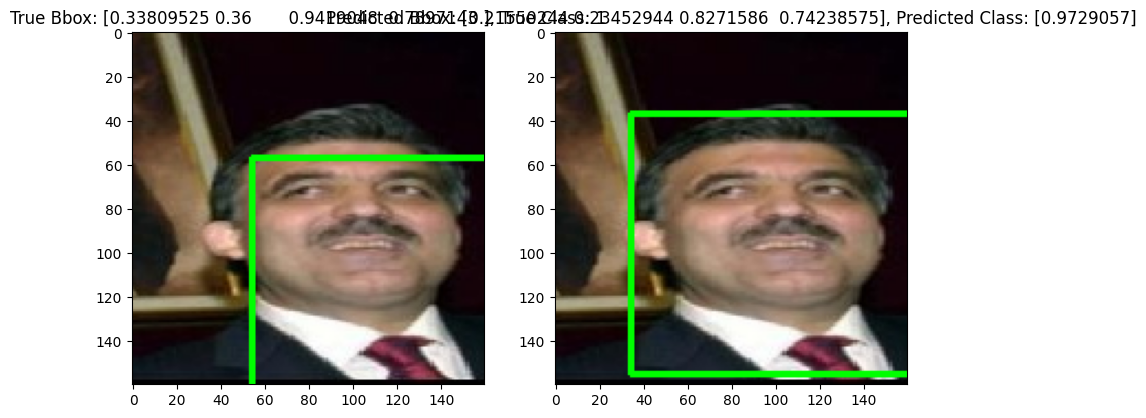

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def draw_bounding_box(image, bbox):
    image_copy = np.copy(image)
    h, w, _ = image_copy.shape

    x, y, width, height = bbox
    x = int(x * w)
    y = int(y * h)
    width = int(width * w)
    height = int(height * h)

    cv2.rectangle(image_copy, (x, y), (x + width, y + height), (0, 255, 0), 2)

    return image_copy


for images, labels in test_dataset:
    predictions = pnet_model.predict(images)

    
    bbox_predictions = predictions['bbox_output']
    class_predictions = predictions['class_output']

    
    idx = np.random.randint(0, len(images))
    image = images[idx].numpy()
    bbox_true = labels['bbox_output'][idx].numpy()
    bbox_pred = bbox_predictions[idx]  
    class_true = labels['class_output'][idx].numpy()
    class_pred = class_predictions[idx]  

    
    image_with_bbox_true = draw_bounding_box(image, bbox_true)
    image_with_bbox_pred = draw_bounding_box(image, bbox_pred)

    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_with_bbox_true)
    plt.title(f'True Bbox: {bbox_true}, True Class: {class_true}')

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_bbox_pred)
    plt.title(f'Predicted Bbox: {bbox_pred}, Predicted Class: {class_pred}')

    plt.show()
